In [60]:
import os
import sys
import glob
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.insert(0, src_path)

from train import validate_model, train_model, plot_training_history
from models import CTClassifier
from datasets import SliceDataset

In [54]:
batch_size = 64
num_workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
random_state = 42

In [55]:
normal_dirs = [
    '/kaggle/input/ct-images/CT/normal',
    '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases',
    '/kaggle/input/large-covid19-ct-slice-dataset/curated_data/curated_data/1NonCOVID',
]

pathology_dirs = [
    '/kaggle/input/ct-images/CT/cancer',
    '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases',
    '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases',
    '/kaggle/input/large-covid19-ct-slice-dataset/curated_data/curated_data/2COVID',
    '/kaggle/input/large-covid19-ct-slice-dataset/curated_data/curated_data/3CAP'
]

paths = []
labels = []

for pathology_path in pathology_dirs:
    all_image_paths = glob.glob(os.path.join(pathology_path, '*'))
    paths.extend(all_image_paths)
    labels.extend([1.0] * len(all_image_paths))

for normal_path in normal_dirs:
    all_image_paths = glob.glob(os.path.join(normal_path, '*'))
    paths.extend(all_image_paths)
    labels.extend([0.0] * len(all_image_paths))

print(f"Всего образцов: {len(paths)}")
print(f"Норма (CT-0): {labels.count(0)}")
print(f"Патология: {labels.count(1)}")

# Разбиение
train_samples, temp_samples, train_labels, temp_labels = train_test_split(
    paths, labels,
    test_size=0.3,
    random_state=random_state,
    stratify=labels,
    shuffle=True
)

val_samples, test_samples, val_labels, test_labels = train_test_split(
    temp_samples, temp_labels,
    test_size=0.5,
    random_state=random_state,
    stratify=temp_labels,
    shuffle=True
)

print(f"\nTrain: {len(train_samples)} ({len(train_samples)/len(paths):.1%})")
print(f"Val:   {len(val_samples)} ({len(val_samples)/len(paths):.1%})")
print(f"Test:  {len(test_samples)} ({len(test_samples)/len(paths):.1%})")

Всего образцов: 21201
Норма (CT-0): 8809
Патология: 12392

Train: 14840 (70.0%)
Val:   3180 (15.0%)
Test:  3181 (15.0%)


In [56]:
train_dataset = SliceDataset(train_samples, train_labels)
val_dataset = SliceDataset(val_samples, val_labels)
test_dataset = SliceDataset(test_samples, test_labels)

train_labels_array = np.array(train_labels)
num_neg = (train_labels_array == 0).sum()
num_pos = (train_labels_array == 1).sum()

print(f"Train balance — норма: {num_neg}, патология: {num_pos} (ratio pos/neg = {num_pos/num_neg:.2f})")

class_weights = 1.0 / np.array([num_neg, num_pos])
sample_weights = class_weights[train_labels_array.astype(int)]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

Train balance — норма: 6166, патология: 8674 (ratio pos/neg = 1.41)


In [57]:
model = CTClassifier(embed_dim=128).to(device)

train_history = train_model(
    model,
    train_loader,
    val_loader,
    device,
    10,
    lr=1e-4,
    wd=1e-5,
    patience=2,
    save_path='best_slice_clf_model.pth'
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1
Train loss = 0.3055
Val metrics: loss = 0.1611, f1-score = 0.9470, precision = 0.9900, recall = 0.9075, ROC-AUC = 0.9880
Saved best model with F1 = 0.9470

Epoch 2
Train loss = 0.1330
Val metrics: loss = 0.0927, f1-score = 0.9720, precision = 0.9819, recall = 0.9623, ROC-AUC = 0.9955
Saved best model with F1 = 0.9720

Epoch 3
Train loss = 0.0975
Val metrics: loss = 0.0902, f1-score = 0.9749, precision = 0.9884, recall = 0.9618, ROC-AUC = 0.9958
Saved best model with F1 = 0.9749

Epoch 4
Train loss = 0.0809
Val metrics: loss = 0.0664, f1-score = 0.9814, precision = 0.9822, recall = 0.9806, ROC-AUC = 0.9978
Saved best model with F1 = 0.9814

Epoch 5
Train loss = 0.0641
Val metrics: loss = 0.0789, f1-score = 0.9798, precision = 0.9923, recall = 0.9677, ROC-AUC = 0.9971

Epoch 6
Train loss = 0.0601
Val metrics: loss = 0.0600, f1-score = 0.9830, precision = 0.9844, recall = 0.9817, ROC-AUC = 0.9979
Saved best model with F1 = 0.9830

Epoch 7
Train loss = 0.0457
Val metrics: loss = 0.

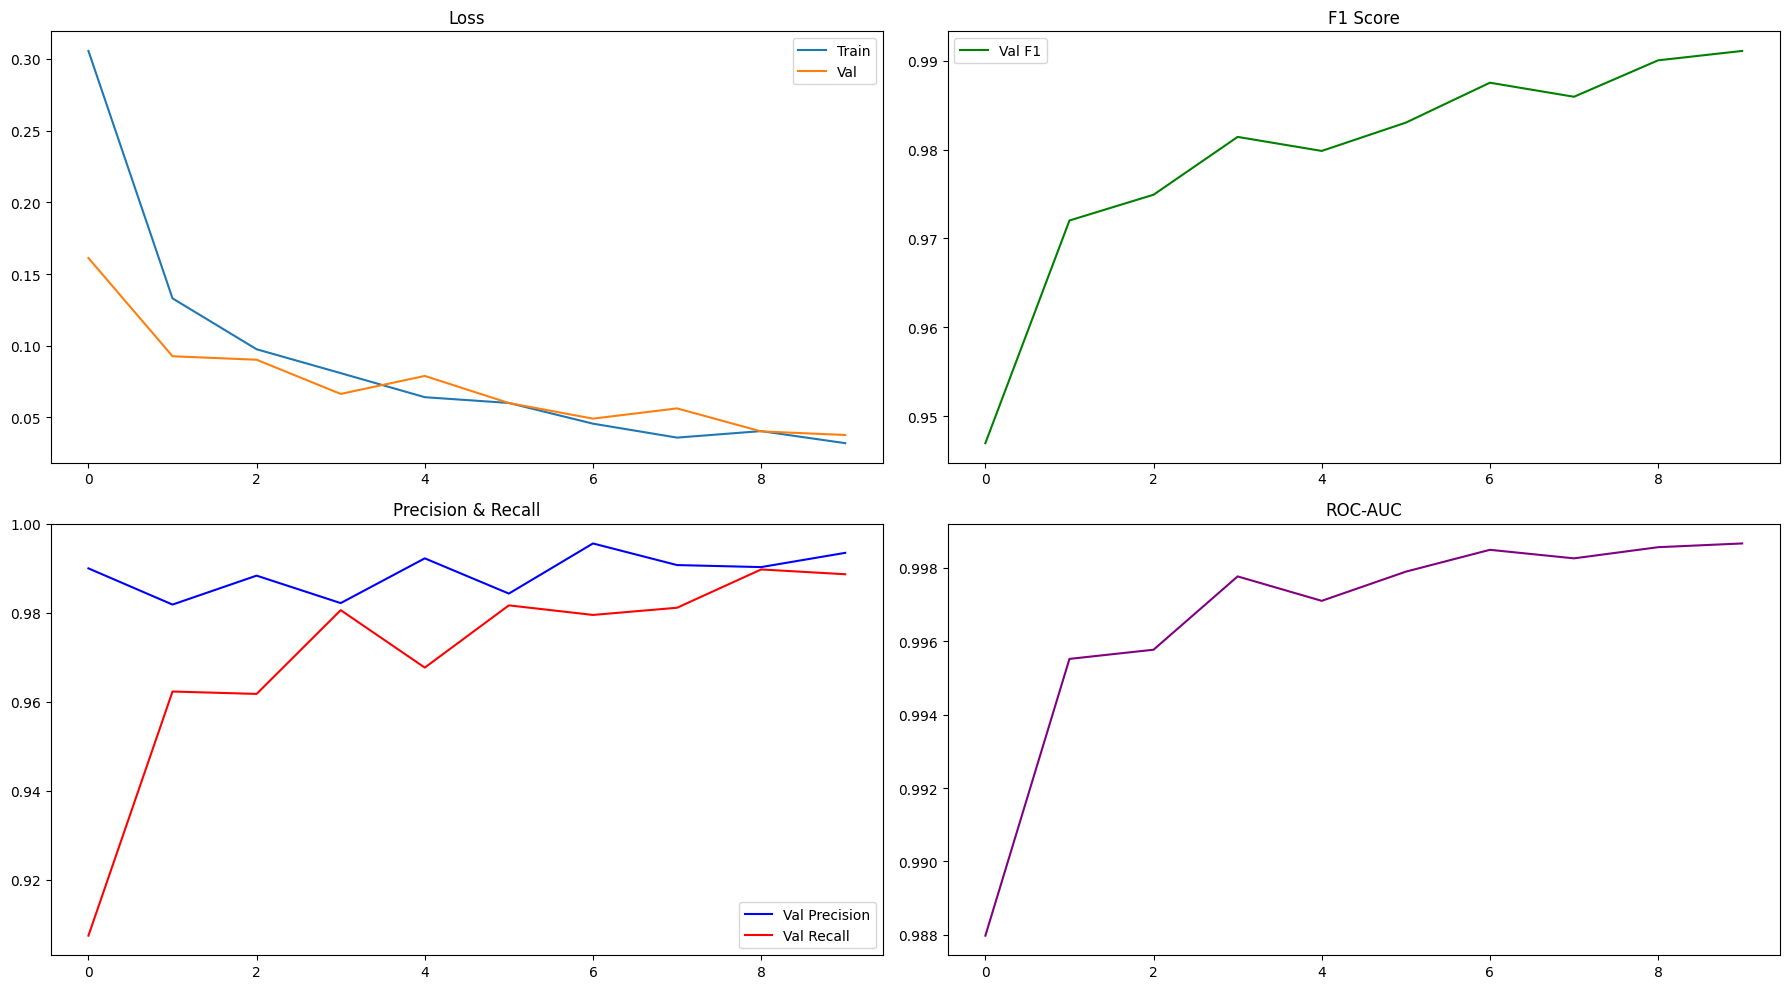

In [58]:
history_plot = plot_training_history(train_history)

In [59]:
test_f1, test_precision, test_recall, test_roc_auc, _ = validate_model(model, test_loader, device)

print("Test metrics:")
print(f"F1-score: {test_f1}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"ROC-AUC: {test_roc_auc}")

Test metrics:
F1-score: 0.9886792452830189
Precision: 0.990815775256618
Recall: 0.9865519096288327
ROC-AUC: 0.9977718080825262


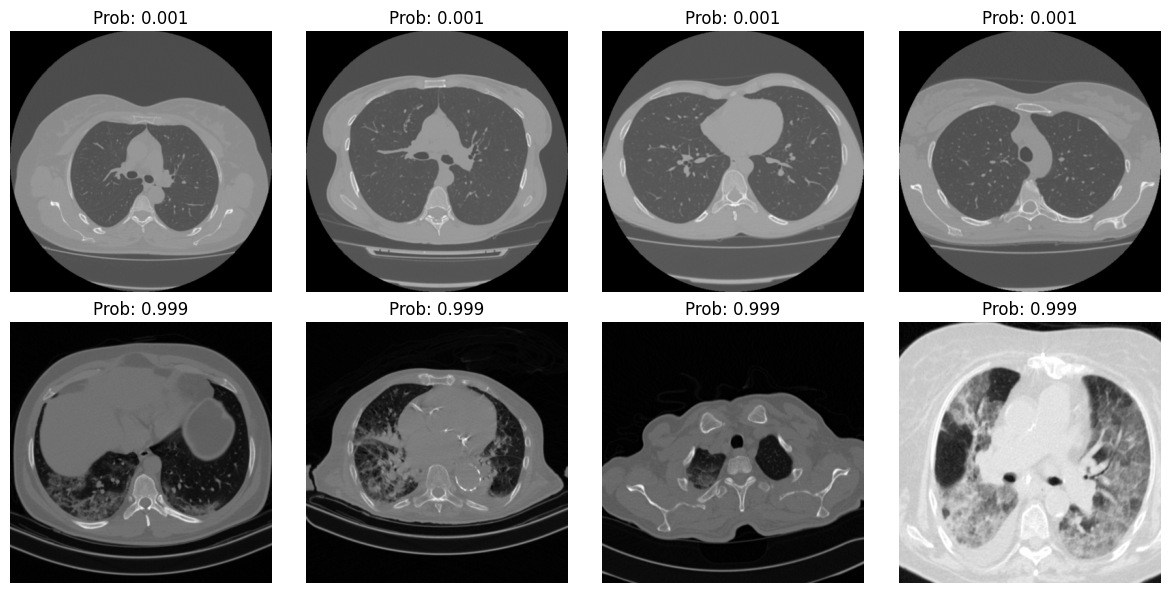

In [68]:
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().numpy()
        break 
        
sorted_indices = np.argsort(probs)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(sorted_indices[:4]):
    plt.subplot(2, 4, i+1)
    img = imgs[idx].cpu().permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Prob: {probs[idx]:.3f}")
    plt.axis('off')

for i, idx in enumerate(sorted_indices[-4:]):
    plt.subplot(2, 4, i+5)
    img = imgs[idx].cpu().permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Prob: {probs[idx]:.3f}")
    plt.axis('off')

plt.tight_layout()
plt.show()